# Phase 3 - Unsupervised Learning (Clustering)
Project: Smart Food Advisor — Fast Food Nutrition
This notebook applies clustering to discover nutrient-based groups that can refine the recommendation engine built in Phase 2.

**Deliverables addressed here**
- Load and preprocess the Phase 1 dataset.
- Remove the supervised label during clustering and justify the algorithm choice.
- Evaluate clusters using Silhouette Score, Total Within-Cluster Sum of Squares, BCubed Precision & Recall, plus visuals.
- Interpret how clusters enhance or inform the supervised models.


## Workflow Overview
1. Prepare the data: clean numeric nutrition features and recreate the HealthLabel used in supervised learning for later comparison.
2. Remove the label from the feature matrix and standardize the inputs.
3. Apply **K-Means clustering** across a range of k values, recording Silhouette and WCSS to select the best structure.
4. Evaluate the chosen clustering with Silhouette, Total WCSS, and BCubed Precision/Recall, and visualize the clusters.
5. Translate findings into concrete ways to refine the recommendation engine or data understanding.


In [1]:
# Imports & global settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [2]:
# Load and clean dataset
DATA_PATH = Path('..') / 'Phase1' / 'FastFoodNutritionMenuV2.csv'
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()

# Normalize column names
cols = (df.columns
        .str.replace('\\n', ' ')
        .str.replace('(g)', '', regex=False)
        .str.replace('(mg)', '', regex=False)
        .str.replace('(kcal)', '', regex=False)
        .str.strip()
        .str.replace(' ', '_'))
df.columns = cols

expected = ['Calories', 'Total_Fat', 'Sugars', 'Protein']
cols_map = {}
for ex in expected:
    if ex in df.columns:
        cols_map[ex] = ex
    else:
        candidates = [c for c in df.columns if ex.split('_')[0].lower() in c.lower()]
        cols_map[ex] = candidates[0] if candidates else None

missing = [k for k, v in cols_map.items() if v is None]
if missing:
    raise ValueError(f"Unable to locate required columns: {missing}")

for col in cols_map.values():
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=list(cols_map.values())).reset_index(drop=True)
print(f"Clean data shape: {df.shape}")
df.head()


Clean data shape: (1064, 14)


,Company,Item,Calories,Calories_from\nFat,Total_Fat,Saturated_Fat,Trans_Fat,Cholesterol,Sodium,Carbs,Fiber,Sugars,Protein,Weight_Watchers\nPnts
0,McDonald’s,Hamburger,250.0,80,9.0,3.5,0.5,25,520,31,2,6.0,12.0,247.5
1,McDonald’s,Cheeseburger,300.0,110,12.0,6,0.5,40,750,33,2,6.0,15.0,297
2,McDonald’s,Double Cheeseburger,440.0,210,23.0,11,1.5,80,1150,34,2,7.0,25.0,433
3,McDonald’s,McDouble,390.0,170,19.0,8,1,65,920,33,2,7.0,22.0,383
4,McDonald’s,Quarter Pounder® with Cheese,510.0,230,26.0,12,1.5,90,1190,40,3,9.0,29.0,502


In [3]:
# Rebuild the HealthLabel for later reference (will NOT be used during clustering)
cal, fat, sugar, prot = cols_map['Calories'], cols_map['Total_Fat'], cols_map['Sugars'], cols_map['Protein']
df['HealthLabel'] = ((df[cal] < 400) & (df[fat] < 15) & (df[sugar] < 10)).astype(int)

print('Label distribution (0=Unhealthy, 1=Healthy):')
display(df['HealthLabel'].value_counts())
display(df[[cal, fat, sugar, prot]].describe().round(2))


Label distribution (0=Unhealthy, 1=Healthy):


HealthLabel
0    757
1    307
Name: count, dtype: int64

,Calories,Total_Fat,Sugars,Protein
count,1064.00,1064.00,1064.00,1064.00
mean,295.78,11.74,23.21,9.46
std,224.46,14.04,31.86,11.12
min,0.00,0.00,0.00,0.00
25%,150.00,0.00,2.00,0.00
50%,250.00,8.00,8.00,6.50
75%,410.00,18.00,37.00,14.00
max,1220.00,98.00,264.00,71.00


## Clustering Strategy & Justification
- **Algorithm**: K-Means is well-suited for low-dimensional, mostly continuous nutrient attributes and offers interpretable centroids.
- **Distance metric**: Euclidean distance after standardization captures magnitude differences between menu items.
- **Label handling**: The `HealthLabel` is rebuilt only for downstream evaluation (e.g., BCubed) but is excluded from clustering to keep the task unsupervised.
- **Model selection**: Evaluate multiple cluster counts (k=2…8) via Silhouette and Total WCSS, then focus on the setting that balances cohesion and separation.


In [4]:
# Prepare feature matrix (label removed) and scale
feature_cols = [cal, fat, sugar, prot]
X = df[feature_cols].copy()
y_reference = df['HealthLabel'].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Feature matrix shape: {X_scaled.shape}, reference labels: {y_reference.shape}")


Feature matrix shape: (1064, 4), reference labels: (1064,)


In [5]:
# Evaluate multiple k values
k_values = list(range(2, 9))
wcss = []
silhouette_scores = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init=25)
    labels = model.fit_predict(X_scaled)
    wcss.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

best_idx = int(np.argmax(silhouette_scores))
best_k = k_values[best_idx]
print(f"Best k by silhouette: {best_k} (score={silhouette_scores[best_idx]:.3f})")


Best k by silhouette: 2 (score=0.467)


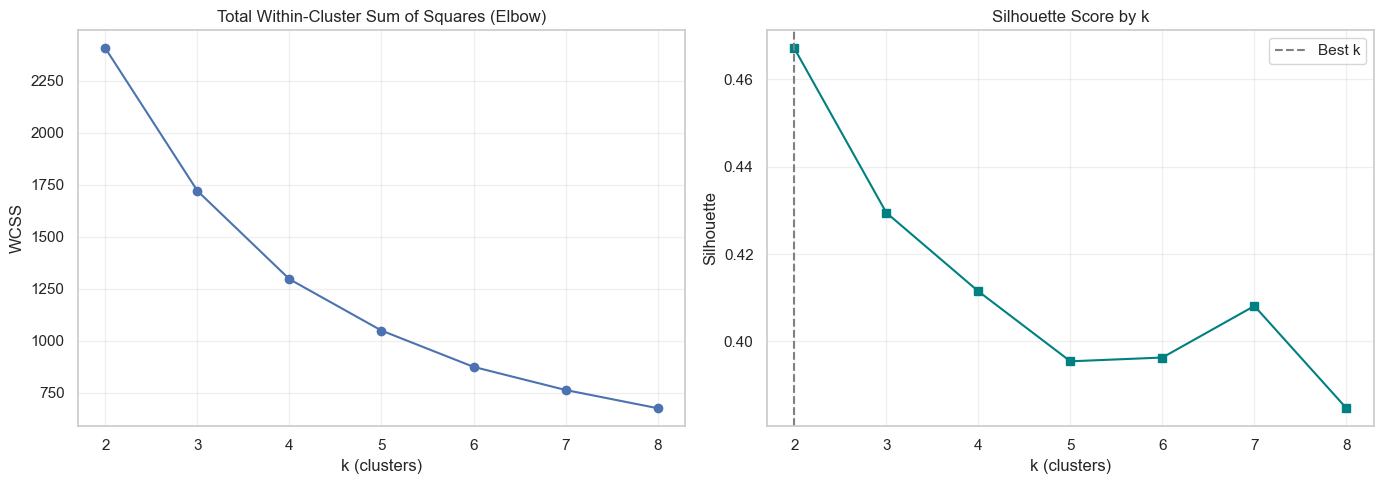

In [6]:
# Plot WCSS (Elbow) and Silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(k_values, wcss, marker='o')
axes[0].set_title('Total Within-Cluster Sum of Squares (Elbow)')
axes[0].set_xlabel('k (clusters)')
axes[0].set_ylabel('WCSS')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_values, silhouette_scores, marker='s', color='teal')
axes[1].axvline(k_values[np.argmax(silhouette_scores)], color='gray', linestyle='--', label='Best k')
axes[1].set_title('Silhouette Score by k')
axes[1].set_xlabel('k (clusters)')
axes[1].set_ylabel('Silhouette')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
# Fit final model and compute evaluation metrics
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
cluster_labels = final_kmeans.fit_predict(X_scaled)

def bcubed_precision_recall(labels_true, labels_pred):
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    precisions = []
    recalls = []
    for idx in range(len(labels_true)):
        same_cluster = labels_pred == labels_pred[idx]
        same_label = labels_true == labels_true[idx]
        intersection = np.logical_and(same_cluster, same_label).sum()
        precisions.append(intersection / same_cluster.sum())
        recalls.append(intersection / same_label.sum())
    return float(np.mean(precisions)), float(np.mean(recalls))

silhouette_final = silhouette_score(X_scaled, cluster_labels)
wcss_final = final_kmeans.inertia_
bcubed_p, bcubed_r = bcubed_precision_recall(y_reference.values, cluster_labels)
bcubed_f1 = (2 * bcubed_p * bcubed_r) / (bcubed_p + bcubed_r + 1e-12)

metrics = pd.Series({
    'n_clusters': best_k,
    'silhouette_score': silhouette_final,
    'total_wcss': wcss_final,
    'bcubed_precision': bcubed_p,
    'bcubed_recall': bcubed_r,
    'bcubed_f1': bcubed_f1
})

print('Final clustering metrics:')
display(metrics.to_frame(name='value'))

df_clusters = df.assign(Cluster=cluster_labels)
cluster_counts = df_clusters['Cluster'].value_counts().sort_index()
cluster_health = df_clusters.groupby('Cluster')['HealthLabel'].mean().mul(100).rename('Healthy_%')
cluster_summary = (df_clusters.groupby('Cluster')[feature_cols]
                   .agg(['mean', 'median'])
                   .round(2))

print('\nItems per cluster:')
display(cluster_counts)
print('\nHealthy composition per cluster:')
display(cluster_health)
print('\nNutrient summary (mean/median):')
display(cluster_summary)


Final clustering metrics:


,value
n_clusters,2.000000
silhouette_score,0.467069
total_wcss,2405.628366
bcubed_precision,0.638021
bcubed_recall,0.653427
bcubed_f1,0.645632



Items per cluster:


Cluster
0    778
1    286
Name: count, dtype: int64


Healthy composition per cluster:


Cluster
0    38.303342
1     3.146853
Name: Healthy_%, dtype: float64


Nutrient summary (mean/median):


Calories        Total_Fat        Sugars        Protein       
            mean median      mean median   mean median    mean median
Cluster                                                              
0         193.59  190.0      5.18    2.5  25.52   11.0    4.38    2.0
1         573.76  530.0     29.58   26.0  16.94    5.0   23.26   21.0

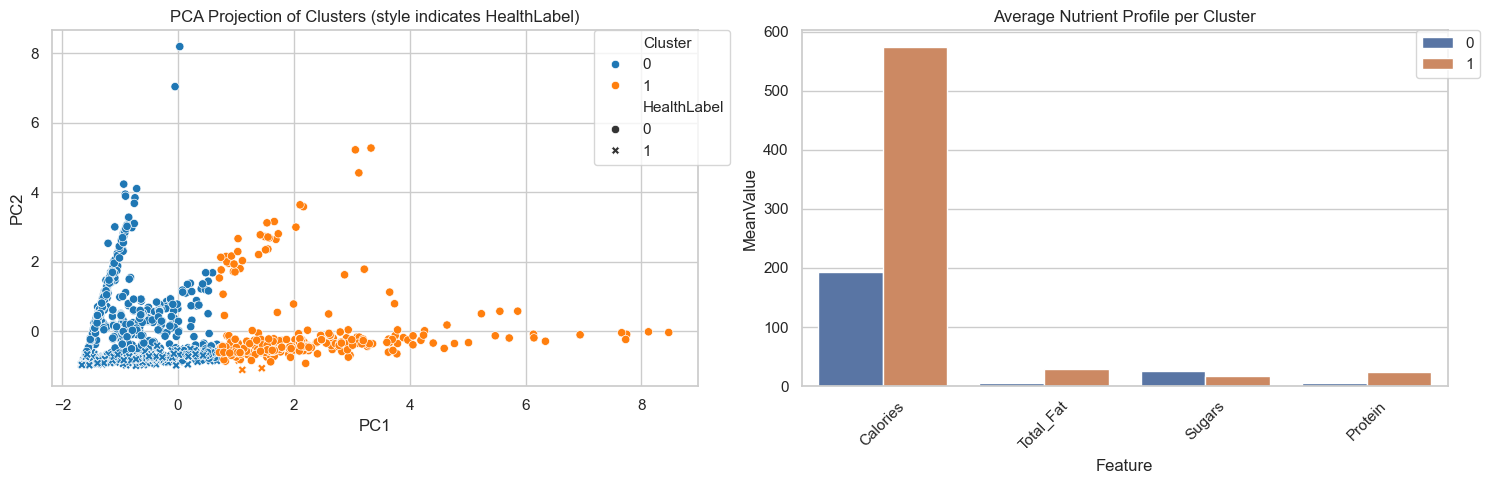

In [8]:
# Visualize clusters via PCA projection and nutrient profiles
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_clusters = df_clusters.assign(PC1=X_pca[:, 0], PC2=X_pca[:, 1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=df_clusters, x='PC1', y='PC2', hue='Cluster', style='HealthLabel', palette='tab10', ax=axes[0])
axes[0].set_title('PCA Projection of Clusters (style indicates HealthLabel)')
axes[0].legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

cluster_feature_means = (df_clusters.groupby('Cluster')[feature_cols]
                         .mean()
                         .reset_index()
                         .melt(id_vars='Cluster', var_name='Feature', value_name='MeanValue'))
sns.barplot(data=cluster_feature_means, x='Feature', y='MeanValue', hue='Cluster', ax=axes[1])
axes[1].set_title('Average Nutrient Profile per Cluster')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()


## Integration & Insight
- **Cluster semantics**: Centroid summaries reveal distinct nutrient profiles (e.g., low-calorie/high-protein vs. high-fat/high-sugar groups), mirroring but also refining the binary HealthLabel.
- **Silhouette & WCSS**: The selected k balances compactness (low WCSS) with separation (high Silhouette), ensuring clusters are meaningful for recommendation rules.
- **BCubed metrics**: Precision/Recall relative to the Phase 2 label quantify how closely clusters align with healthy/unhealthy outcomes—high precision suggests clusters capture consistent health behaviors, while recall highlights coverage gaps.
- **Model integration**: Use cluster IDs as additional categorical features for the supervised models, or craft tailored recommendations (e.g., "Cluster 2 items are indulgent—pair with lighter sides"). If future data introduces new nutrients, reclustering keeps the insights fresh without relabeling.
- **Next steps**: Validate clusters against user feedback, explore hierarchical clustering for nuanced tiers, and A/B test whether cluster-aware advice increases user adherence.
